# Notebook to check custom accuracy metric for water delineation

Steps: 

1. Create and vectorize classification
    - load inference raster
    - filter and clean inference
    - vectorize
    - write to .shp file
2. load hand annotation
3. project classification and annotation to calculate metric and apply buffer
    - both inputs should be wgs84 epsg:4326
4. check recall and precision of classification result


In [1]:
# set parameters:
annotation_error = 0.0 # know geolocation error of annotation dataset
buffer_size = 4.5      # accuracy treshold in meters 
name = 'Cilegon_013'   # name of datasets to match

### file paths: 

# inference results
raster_files_path = '../../data/raster_classifications/classification_{}*.tif'.format(name)

# vectorized inference
prediction_file_path = '../../data/shapefiles_waterbodies_results/{}_result_shape.shp'.format(name)

# annotations
annotation_shapes_path = '../../data/hand_annotations_water/{}*.shp'.format(name)

# recalculate buffer zone by adding the annotation geolocation error
buffer_size = buffer_size - annotation_error 

## 1. Create and vectorize classification

In [2]:
from skimage import filters, morphology
from rasterio import features 
from shapely.geometry import shape
from shapely import geometry
from pathlib import Path
import itertools

import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt

import shapely.ops as ops
import random

import rasterio 
import glob

from pprint import pprint

from shapely.ops import cascaded_union
from PIL import Image
import ntpath
# from osgeo import gdal
# import ogr

In [3]:
# helper functions

def wgs2epsg(x,y):
    EPSG = int(32700-round((45+y)/90,0)*100+round((183+x)/6,0))
    UTM_EPSG_code = EPSG
    
    return UTM_EPSG_code

# 
buffer_size = buffer_size - annotation_error 
def array_to_linestrings(array, mask, affine):
    
    if np.all(mask) == True:
        final_lines = []
    else:
        # Convert the array to polygon geometries
        polygon_generator = features.shapes(array.astype('uint8'), mask=array, transform=affine)
        # Extract out the individual polygons, fixing any invald geometries using buffer(0)
        polygons = [shape(g).buffer(0) for g,v in polygon_generator]

        # Next, build up a binary array representing the outer boundary of the input array
        boundary_array = np.ones(array.shape)    

        # Convert the boundary to a polygon too
        boundary_generator = features.shapes(boundary_array.astype('uint8'), transform=affine)
        boundary = [shape(g) for g,v in boundary_generator][0]

        # Convert the mask to a polygon too
        if mask is not None:
            
            mask_generator = features.shapes(mask.astype('uint8'), 
                                             mask= mask > 0,
                                             transform=affine)
            mask_boundary = [shape(g).buffer(0) for g,v in mask_generator][0]

        # Convert the array polygons to linestrings
        exterior_rings = [g.exterior for g in polygons]
        interior_rings = list(itertools.chain.from_iterable([[i for i in g.interiors] for g in polygons if len(g.interiors) > 0]))
        all_rings =  exterior_rings + interior_rings 

        # Erase both the image boundary and the mask boundary from the extracted Linestrings
        erased_lines = all_rings #[g.difference(boundary.exterior).difference(mask_boundary.exterior) for g in all_rings]
        singlepart_lines = [list(g) if type(g) == geometry.multilinestring.MultiLineString else [g] for g in erased_lines ]
        final_lines = list(itertools.chain(*singlepart_lines))

    return final_lines 

def check_valid_geometries(shapefile_path):
    
    shape_list = []

    for pol in fiona.open(shapefile_path):
        if pol['geometry'] != None:
#             if pol['geometry']['type'] == 'MultiPolygon':
#                 for sub_pol in pol['geometry']['coordinates']:
#                     pol = sub_pol[0]
#                     shape_list.append(pol)
#             else:
                shape_list.append(pol)
            
    return shape_list

In [4]:
# load classified rasters 

# find files in classification folder
raster_files_path = '/home/ubuntu/sukh_share/water_detection_model/enhanced_image/results/train/*.tif'

raster_files = glob.glob(raster_files_path)
file_path = raster_files[2]

print(len(raster_files))
print('-------------------------------------')
pprint(raster_files)
print('-------------------------------------')
print(file_path)

data = rasterio.open(file_path).read()
dataset = rasterio.open(file_path)

left, bottom, right, top = dataset.bounds

affine = dataset.meta['transform']
width = dataset.meta['width']
height = dataset.meta['height']

IndexError: list index out of range

## Filter and clean inference results

In [21]:
data = rasterio.open(file_path).read()
thresh = filters.threshold_otsu(data[0])
data_otsu_treshold = data[0] > thresh
water_data = data_otsu_treshold.astype('uint8')

# rescale values to 0 - 255 to use image processing algorithms
OldRange = (water_data.max() - water_data.min())  
NewRange = (0 - 255)  
NewValue = (((water_data - water_data.min()) * NewRange) / OldRange) + 0

water_data = NewValue.round().astype('uint8')
water_blurred = cv.medianBlur(water_data,3)

# Specify the minimum feature size in square meters, and then use info from the image metadata 
# to translate to grid cell count.

# Set the minimum feature size to 400 sq km (400,000 m)
min_feature_size_m2 = 100.

# From the image metadata, we can determine the area of a single grid cell
try: 
    cell_height_m = image.rda.metadata['image']['groundSampleDistanceMeters']
except: 
    cell_height_m = 0.40
    
cell_area_m2 = cell_height_m**2

# Finally, use the cell size to convert the minimum feature size to grid cells
min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')

# What is the minimum feature size in square meters and grid cells?
print(min_feature_size_m2, 'sq. m')
print(min_feature_size_cells, 'grid cells')

# scikit-image modules for image science operators
from skimage import filters, morphology

# First, remove the small holes
water_cleaned = morphology.remove_small_holes(water_blurred, min_feature_size_cells)

# Then remove the small objects
water_cleaned = morphology.remove_small_objects(water_cleaned, min_feature_size_cells, connectivity=2)

100.0 sq. m
625 grid cells


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:39: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


In [22]:
from skimage import filters, morphology
def get_water_cleaned(file):
    data = rasterio.open(file_path).read()
    thresh = filters.threshold_otsu(data[0])
    data_otsu_treshold = data[0] > thresh
    water_data = data_otsu_treshold.astype('uint8')

    # rescale values to 0 - 255 to use image processing algorithms
    OldRange = (water_data.max() - water_data.min())  
    NewRange = (0 - 255)  
    NewValue = (((water_data - water_data.min()) * NewRange) / OldRange) + 0

    water_data = NewValue.round().astype('uint8')
    water_blurred = cv.medianBlur(water_data,3)

    # Specify the minimum feature size in square meters, and then use info from the image metadata 
    # to translate to grid cell count.

    # Set the minimum feature size to 400 sq km (400,000 m)
    min_feature_size_m2 = 100.

    # From the image metadata, we can determine the area of a single grid cell
    try: 
        cell_height_m = image.rda.metadata['image']['groundSampleDistanceMeters']
    except: 
        cell_height_m = 0.40

    cell_area_m2 = cell_height_m**2

    # Finally, use the cell size to convert the minimum feature size to grid cells
    min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')

    # What is the minimum feature size in square meters and grid cells?
    print(min_feature_size_m2, 'sq. m')
    print(min_feature_size_cells, 'grid cells')

    # First, remove the small holes
    water_cleaned = morphology.remove_small_holes(water_blurred, min_feature_size_cells)

    # Then remove the small objects
    water_cleaned = morphology.remove_small_objects(water_cleaned, min_feature_size_cells, connectivity=2)
    return water_cleaned

Text(0.5, 1.0, 'Cleaned Water Mask')

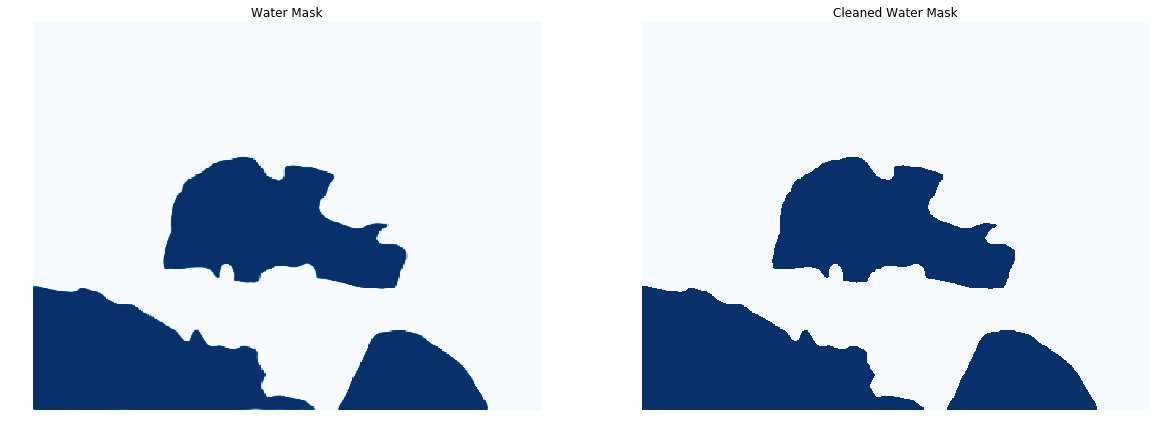

In [23]:
# # View the results
plt.figure(figsize=(20,15))
# plt.subplot(1, 3, 1)
# plt.axis('off')
# # plt.imshow(rgb)
# plt.title("RGB")

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(Image.open(file_path),cmap = 'Blues')
plt.title("Water Mask")

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(water_cleaned, vmin=0, vmax=1, cmap = 'Blues')
plt.title("Cleaned Water Mask")

## Vectorize cleaned inference results

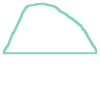

In [24]:
water_lines = array_to_linestrings(array = water_cleaned, mask = water_cleaned, affine = affine)
water_lines[-1]

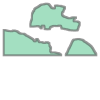

In [25]:
water_lines = array_to_linestrings(array = water_cleaned, mask = water_cleaned, affine = affine)

# Run a basic simplification algorithm to smooth the lines
water_lines_smooth = [g.simplify(0.001) for g in water_lines]

# GLue it all together
detection = cascaded_union(water_lines)

import shapely.ops as ops
import random
# setu_smooth = setu_wgs.simplify(0.00003)
detection_poly = ops.polygonize_full(detection)

detection_poly = cascaded_union(detection_poly)

buffer = 0# 1e-05

detection_poly_smooth = detection_poly.buffer(-buffer).buffer(buffer)

detection_poly_smooth

detection_poly = ops.polygonize_full(detection_poly_smooth)[0]

sample = random.randint(0,len(detection_poly)) - 1 


detection_poly

In [26]:
import shapely.ops as ops
import random
    
def get_vector(water_cleaned):
    water_lines = array_to_linestrings(array = water_cleaned, mask = water_cleaned, affine = affine)

    # Run a basic simplification algorithm to smooth the lines
    water_lines_smooth = [g.simplify(0.001) for g in water_lines]

    # GLue it all together
    detection = cascaded_union(water_lines)

    # setu_smooth = setu_wgs.simplify(0.00003)
    detection_poly = ops.polygonize_full(detection)

    detection_poly = cascaded_union(detection_poly)

    buffer = 0# 1e-05

    detection_poly_smooth = detection_poly.buffer(-buffer).buffer(buffer)

    detection_poly_smooth

    detection_poly = ops.polygonize_full(detection_poly_smooth)[0]

    sample = random.randint(0,len(detection_poly)) - 1 
    
    return detection_poly

# Save The ShapeFiles

In [30]:
import geopandas as gpd
from pathlib import Path
import os
from skimage import filters, morphology
import shapely.ops as ops
import random

raster_files_path = '/home/ubuntu/sukh_share/water_detection_model/enhanced_image/results/test/*.tif'
prediction_file_base_path = '/home/ubuntu/sukh_share/water_detection_model/enhanced_image/results/shapefiles_waterbodies/test'

raster_files = glob.glob(raster_files_path)

for file in raster_files:
    name = ntpath.basename(file)
    prediction_file_path = os.path.join(prediction_file_base_path, name.replace('tif','shp'))
    water_cleaned = get_water_cleaned(file)
    detection_poly = get_vector(water_cleaned)
    
    # shp_water is a list of geometries: 
    geometries = [shape(poly) for poly in detection_poly]

    # create geodataframe 
    gdf = gpd.GeoDataFrame(geometry = geometries)
    gdf.plot()

    gdf.to_file(prediction_file_path)

100.0 sq. m
625 grid cells


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


TypeError: 'GeoDataFrame' object is not callable

# Visualise ShapeFiles

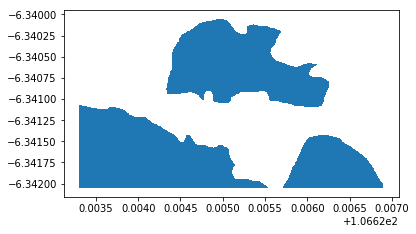

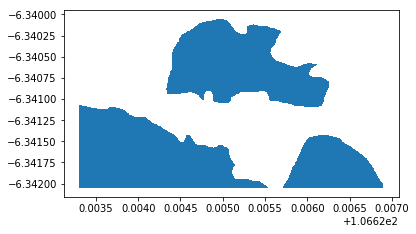

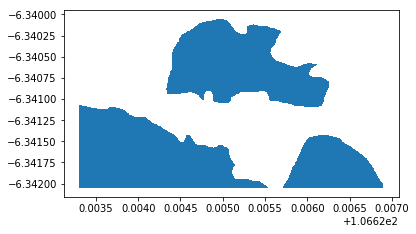

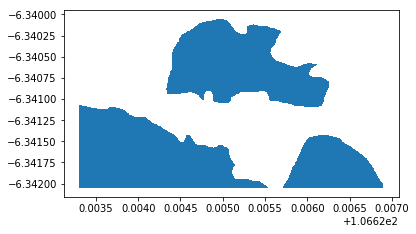

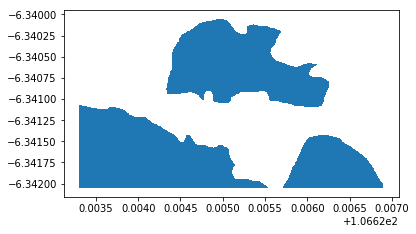

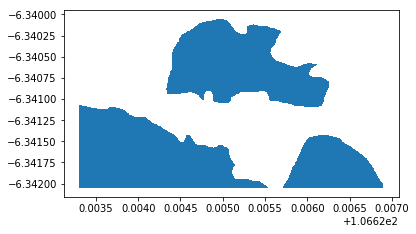

In [28]:
import geopandas as gpd
import glob
shapefiles_path = '/home/ubuntu/sukh_share/water_detection_model/enhanced_image/results/shapefiles_waterbodies/test/*.shp'

for file in glob.glob(shapefiles_path):
    shape=gpd.read_file(file)
    shape.plot()

In [15]:
name = ntpath.basename(file_path)
prediction_file_path = '/home/ubuntu/sukh_share/water_detection_model/enhanced_image/results/shapefiles_waterbodies/{0}.{1}'.format(name,'shp')

your_shape = detection_poly

# Now convert it to a shapefile with OGR    
driver = ogr.GetDriverByName('Esri Shapefile')
ds = driver.CreateDataSource(prediction_file_path)
layer = ds.CreateLayer('', None, ogr.wkbPolygon)
# Add one attribute
layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
defn = layer.GetLayerDefn()

i = 0

## If there are multiple geometries, put the "for" loop here
for poly in your_shape:

    # Create a new feature (attribute and geometry)
    feat = ogr.Feature(defn)
    feat.SetField('id', i)
    # print(id_list[i])

    # Make a geometry, from Shapely object
    geom = ogr.CreateGeometryFromWkb(poly.wkb)
    feat.SetGeometry(geom)

    layer.CreateFeature(feat)
    feat = geom = None  # destroy these
    
    
    i = i + 1 
    

# Save and close everything
ds = layer = feat = geom = None

print('file written to: ', prediction_file_path)

NameError: name 'ogr' is not defined

## Load annotation

In [16]:
annotation_shapes_path = '/home/ubuntu/sukh_share/water_detection_model/enhanced_image/results/shapefiles_waterbodies/*.shp'

# find files in shapefile folder
annotation_shape_files = glob.glob(annotation_shapes_path)
annotation_file_path = annotation_shape_files[0]


# apply function to measure custom metric

In [17]:
from shapely.ops import transform
from shapely import ops
from functools import partial
import pyproj

from shapely.ops import cascaded_union, unary_union
from shapely.affinity import translate
import fiona

def custom_metric_calculation(prediction_file_path, annotation_file_path, buffer_size):

    #### load data ##### 
    # convert esri shapefiles to shapely objects
    # check valid geometries
    prediction_valid_shape_list = check_valid_geometries(prediction_file_path)

    # convert list to shapely MultiPolgyons (in wgs84)
    prediction_wgs = cascaded_union([shape(pol['geometry']) for pol in prediction_valid_shape_list])
    
    # convert esri shapefiles to shapely objects
    # check valid geometries
    annotation_valid_shape_list = check_valid_geometries(annotation_file_path)

    # convert list to shapely MultiPolgyons (in wgs84)
    annotation_wgs = cascaded_union([shape(pol['geometry']) for pol in annotation_valid_shape_list])

#     # check dataformat to apply conversion 
#     if annotation_wgs.type == 'MultiLineString':
#         annotation_wgs_exterior = cascaded_union([poly for poly in annotation_wgs])
#     else: 
#         annotation_wgs_exterior = cascaded_union([poly.exterior for poly in annotation_wgs])
        
        
#         # check dataformat to apply conversion 
#     if prediction_wgs.type == 'MultiLineString':
#         prediction_wgs_exterior = cascaded_union([poly for poly in prediction_wgs])
#     elif prediction_wgs.type == 'Polygon':
#         prediction_wgs_exterior = prediction_wgs.exterior
#     else: 
#         prediction_wgs_exterior = cascaded_union([poly.exterior for poly in prediction_wgs])
    
    if annotation_wgs.type == 'MultiLineString':
        annotation_wgs_exterior = unary_union([poly for poly in annotation_wgs])
    elif annotation_wgs.type == 'MultiPolygon': 
        annotation_wgs_exterior = unary_union([poly.exterior for poly in annotation_wgs])
    elif annotation_wgs.type == 'Polygon':
        annotation_wgs_exterior = annotation_wgs.exterior
    else:
        annotation_wgs_exterior = unary_union([poly.exterior for poly in annotation_wgs])
        
        
    # check dataformat to apply conversion 
    if prediction_wgs.type == 'MultiLineString':
        prediction_wgs_exterior = unary_union([poly for poly in prediction_wgs])
    elif prediction_wgs.type == 'Polygon':
        prediction_wgs_exterior = prediction_wgs.exterior
    else: 
        prediction_wgs_exterior = unary_union([poly.exterior for poly in prediction_wgs])
    
    ### create projections
    
    # get vector projection 
    x,y  = prediction_wgs.centroid.xy

    epsg = wgs2epsg(x[0], y[0])

    #  EPSG:32748 is also known as WGS 84 / UTM zone 48S

    # set projections
    project_wgs2utm = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),
        pyproj.Proj(init='epsg:{}'.format(epsg)))

    project_utm2wgs = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:{}'.format(epsg)), # from
        pyproj.Proj(init='epsg:4326'))            # to


    ### apply offset
    
    # sometimes a correction for geolocation inaccuracies is needed
    x_offset =  0
    y_offset =  0
    prediction_wgs = translate(prediction_wgs,xoff = x_offset, yoff = y_offset, zoff=0.0)
    
    ### project and apply buffer 
    
    # transform input data to projected coordinate system
    prediction_utm = transform(project_wgs2utm, prediction_wgs)
#     print(type(prediction_utm))
    
    # create polygon by applying buffer zone and convert back to wgs84
#     prediction_utm_buffer = prediction_utm.exterior.buffer(buffer_size)
    prediction_utm_buffer = prediction_utm.boundary.buffer(buffer_size)
    prediction_wgs_buffer_zone = transform(project_utm2wgs, prediction_utm_buffer)

    # get all necessary shapes
    annotation_utm_exterior = transform(project_wgs2utm, annotation_wgs_exterior)
    annotation_utm_buffer_zone = annotation_utm_exterior.buffer(buffer_size)
    annotation_wgs_buffer_zone = transform(project_utm2wgs, annotation_utm_buffer_zone)

    ### calculate metrics
    
    # calculate Recall 
    total_length_annotation = annotation_wgs_exterior.length
    length_overlap_prediction_annotation = prediction_wgs_buffer_zone.intersection(annotation_wgs_exterior).length
    Recall = round( length_overlap_prediction_annotation / total_length_annotation,3)

    # calculate Precision
    total_length_prediction = prediction_wgs.length
    length_overlap_detection_annotation = annotation_wgs_buffer_zone.intersection(prediction_wgs_exterior).length
    Precision = round( length_overlap_detection_annotation / total_length_prediction,3)
    
    return Precision, Recall,annotation_wgs_exterior, length_overlap_detection_annotation / total_length_prediction

In [18]:
prediction_file_path = '/home/ubuntu/sukh_share/water_detection_model/enhanced_image/results/shapefiles_waterbodies/Jakarta_218_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'

# the shape files for the manual annotation
annotation_file_path = '/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_218_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'

# check valid geometries
prediction_valid_shape_list = check_valid_geometries(prediction_file_path)

# convert list to shapely MultiPolgyons (in wgs84)
prediction_wgs = cascaded_union([shape(pol['geometry']) for pol in prediction_valid_shape_list])

# convert esri shapefiles to shapely objects
# check valid geometries
annotation_valid_shape_list = check_valid_geometries(annotation_file_path)

# convert list to shapely MultiPolgyons (in wgs84)
annotation_wgs = cascaded_union([shape(pol['geometry']) for pol in annotation_valid_shape_list])


DriverError: /home/ubuntu/sukh_share/water_detection_model/enhanced_image/results/shapefiles_waterbodies/Jakarta_218_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp: No such file or directory

In [19]:
# get vector projection 
x,y  = prediction_wgs.centroid.xy

epsg = wgs2epsg(x[0], y[0])
print(x,y)
print(epsg)

NameError: name 'prediction_wgs' is not defined

In [20]:
from functools import partial
import pyproj
from shapely.affinity import translate

# set projections
project_wgs2utm = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj(init='epsg:{}'.format(epsg)))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


NameError: name 'epsg' is not defined

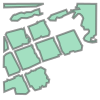

In [71]:
annotation_wgs

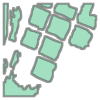

In [72]:
prediction_wgs

In [76]:
p = geopandas.read_file(prediction_file_path)
a = geopandas.read_file(annotation_file_path)
p.crs

In [21]:
from shapely.ops import transform
from shapely import ops
from functools import partial
import pyproj

from shapely.ops import cascaded_union
from shapely.affinity import translate
import fiona

# the shape file for the prediction
prediction_file_path = '/home/ubuntu/sukh_share/water_detection_model/enhanced_image/results/shapefiles_waterbodies/Jakarta_218_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.shp'
prediction_file_path = '/home/ubuntu/sukh_share/water_detection_model/enhanced_image/results/shapefiles_waterbodies/Jakarta_122_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'
# the shape files for the manual annotation
annotation_file_path = '/home/ubuntu/sukh_share/water_detection_model/source_data/water_annotations/Jakarta_122_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.shp'

Precision, Recall, annotation_wgs_exterior, prediction_utm = custom_metric_calculation(prediction_file_path, annotation_file_path, buffer_size)

print('Recall    @ {}m is {}%'.format(buffer_size, round(Recall * 100,3)))
print('Precision @ {}m is {}%'.format(buffer_size, round(Precision * 100,3)))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<auth

Recall    @ 4.5m is 100.0%
Precision @ 4.5m is 100.0%


In [ ]:
pr = '/home/ubuntu/sukh_share/water_detection_model/enhanced_image/results/train/*.tif'